# Table of Contents
* [Load data](#Load-data)
* [Load models](#Load-models)
* [Show errors](#Errors)
* [Boxplots](#Boxplots-residuals)
* [Permutation plots](#Permutation-plots)
* [Runtime plots](#Runtime-analysis)

In [1]:
from ml import data_load_SYKE_S3
from ml import models
from ml import ml_regression
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ml import Py4R_plots
import joblib
import warnings
warnings.filterwarnings("ignore")

## Load data
[Table of Contents](#Table-of-Contents)

In [2]:
##Load the input data and split in training and test
skdata_X_train, skdata_X_test, skdata_y_train, skdata_y_test = data_load_SYKE_S3.load_SYKE()
mean_y_train = np.mean(skdata_y_train)

## Load models
[Table of Contents](#Table-of-Contents)

In [3]:
##Load the all the models trained and stored in the 'models' folder
modelos = {}
table_preds = {}
for bands_name in data_load_SYKE_S3.bands_try_SYKE:
    for model in models.ALL_NAME_MODELS:
        file_model = os.path.join(data_load_SYKE_S3.PATH_TO_MODELS_SYKE,
                                  model+'_'+bands_name+'.pkl')
        if not os.path.exists(file_model):
            print("File %s does not exist"%file_model)
            continue
        
        print("Loading model & make test preds from file %s"%file_model)
        
        regressor_sklearn = joblib.load(file_model)
        modelos[model+"_"+bands_name] =regressor_sklearn 

        table_preds[model+"_"+bands_name] = regressor_sklearn.predict(skdata_X_test[data_load_SYKE_S3.bands_try_SYKE[bands_name]])+mean_y_train

table_preds = pd.DataFrame(table_preds)

Loading model & make test preds from file /Users/abruescas/Desktop/Conferencias_2022/IOCCG/mlregocean-cdom/models/RLR_S3ratio1.pkl
Loading model & make test preds from file /Users/abruescas/Desktop/Conferencias_2022/IOCCG/mlregocean-cdom/models/RFR_S3ratio1.pkl
Loading model & make test preds from file /Users/abruescas/Desktop/Conferencias_2022/IOCCG/mlregocean-cdom/models/Polyfit_S3ratio1.pkl
Loading model & make test preds from file /Users/abruescas/Desktop/Conferencias_2022/IOCCG/mlregocean-cdom/models/RLR_S3ratio2.pkl
Loading model & make test preds from file /Users/abruescas/Desktop/Conferencias_2022/IOCCG/mlregocean-cdom/models/RFR_S3ratio2.pkl
Loading model & make test preds from file /Users/abruescas/Desktop/Conferencias_2022/IOCCG/mlregocean-cdom/models/Polyfit_S3ratio2.pkl
File /Users/abruescas/Desktop/Conferencias_2022/IOCCG/mlregocean-cdom/models/RLR_ratios_S3.pkl does not exist
File /Users/abruescas/Desktop/Conferencias_2022/IOCCG/mlregocean-cdom/models/RFR_ratios_S3.pkl d

In [4]:
##Visualize prediction by data points and models (test dataset)
table_preds

,RLR_S3ratio1,RFR_S3ratio1,Polyfit_S3ratio1,RLR_S3ratio2,RFR_S3ratio2,Polyfit_S3ratio2,RLR_S3bands&ratios,RFR_S3bands&ratios
0,6.947445,6.0032,6.347968,6.098870,5.77815,6.061642,5.621770,5.5582
1,14.693913,12.2672,13.492456,12.111350,11.66860,11.509644,11.117616,11.1110
2,5.995565,6.0972,5.631594,5.632053,6.35460,5.662481,5.722908,5.5684
3,12.068447,10.2242,10.808709,13.105841,12.33855,12.465666,9.959642,10.2216
4,0.879812,2.7824,2.387122,1.624438,2.85805,2.376953,2.512819,2.2808
...,...,...,...,...,...,...,...,...
1384,12.060633,9.0974,10.801123,10.483948,10.25500,9.978810,11.065835,11.1284
1385,3.727940,3.9204,4.067436,3.384185,4.32220,3.788468,3.846509,4.0174
1386,-0.298815,1.5296,1.784359,0.962960,2.12000,1.858991,1.674902,2.0250
1387,5.391101,4.9996,5.195035,4.983122,5.52990,5.113303,5.048210,4.9428


## Errors
[Table of Contents](#Table-of-Contents)

In [5]:
##Load and define the metrics to be used
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
bands_ordered = ['S3ratio1', 'S3ratio2', 'S3bands&ratios']#'ratios_S3','S3bands',
datos = []

def pearson(y_true,y_pred):
    val,_ = pearsonr(y_true,y_pred)
    return val

def root_mean_squared_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def rmse_rel(y_true,y_pred):
    return np.sqrt(np.mean(((y_pred - y_true) / y_true) ** 2))

def bias(y_true,y_pred):
    return np.mean(y_pred - y_true)

   
metrics = [r2_score,bias, mean_absolute_error,pearson,
           root_mean_squared_error,rmse_rel ]

In [6]:
##Calculate metrics by dataset and model (training vs. test)
for b in bands_ordered:
    p = len(data_load_SYKE_S3.bands_try_SYKE[b])
    for m in models.ALL_NAME_MODELS:
        dato = {"model":m,"band":b}
        for metric in metrics:
            if m+"_"+b in table_preds:
                dato[metric.__name__] = metric(skdata_y_test,table_preds[m+"_"+b].values)
        
        n = skdata_X_train.shape[0]
        if "r2_score" in dato:
            dato["r2_adjusted"] = 1-(1-dato["r2_score"])*(n-1)/(n-p-1)
        
        if len(dato.keys())>2:
            datos.append(dato)
            
datos = pd.DataFrame(datos)  
datos.set_index(["band","model"])

r2_score      bias  mean_absolute_error   pearson  \
band           model                                                        
S3ratio1       RLR      0.891409  0.063641             1.710704  0.944189   
               RFR      0.903250  0.015977             1.318640  0.950933   
               Polyfit  0.936492  0.004570             1.048337  0.967878   
S3ratio2       RLR      0.947904  0.014929             1.136296  0.973608   
               RFR      0.932933 -0.050386             1.230348  0.966037   
               Polyfit  0.959429 -0.006575             0.994715  0.979515   
S3bands&ratios RLR      0.990981  0.005669             0.464497  0.995481   
               RFR      0.996856 -0.003498             0.145404  0.998427   

                        root_mean_squared_error  rmse_rel  r2_adjusted  
band           model                                                    
S3ratio1       RLR                     2.630583  0.745910     0.891383  
               RFR                     2.483027  0.172982     0.903226  
               Polyfit                 2.011728  0.133168     0.936477  
S3ratio2       RLR                     1.822037  0.322409     0.947891  
               RFR                     2.067328  0.207103     0.932917  
               Polyfit                 1.607914  0.186078     0.959419  
S3bands&ratios RLR                     0.758131  0.174396     0.990950  
               RFR                     0.447573  0.040476     0.996846

## Boxplots (residuals)
[Table of Contents](#Table-of-Contents)

In [7]:
##Residuals of the models to be plotted
table_residuals = table_preds.copy()

for c in table_preds.columns:
    table_residuals[c] = table_preds[c] - skdata_y_test

table_residuals = pd.melt(table_residuals,var_name="model_band")
table_residuals["model"] = table_residuals["model_band"].apply(lambda x: x.split("_")[0])
table_residuals["band"] = table_residuals["model_band"].apply(lambda x: "_".join(x.split("_")[1:]))
table_residuals.head()

,model_band,value,model,band
0,RLR_S3ratio1,1.407445,RLR,S3ratio1
1,RLR_S3ratio1,3.623913,RLR,S3ratio1
2,RLR_S3ratio1,0.455565,RLR,S3ratio1
3,RLR_S3ratio1,1.888447,RLR,S3ratio1
4,RLR_S3ratio1,-1.380188,RLR,S3ratio1


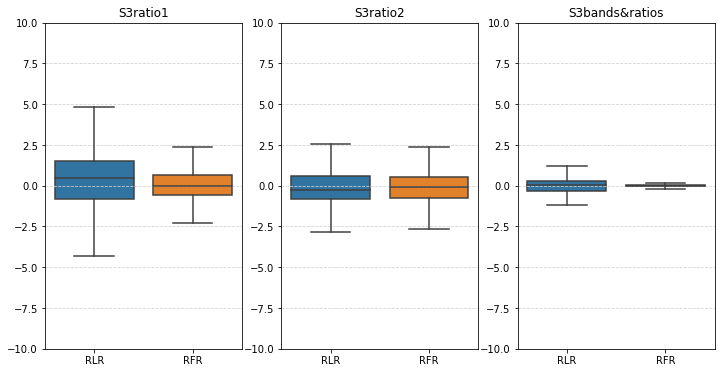

In [8]:
##Boxplot the residuals: the narrower the plot the better
fig,axs = plt.subplots(1,3,figsize=(12,6))

for ax,lab in zip(axs,["S3ratio1", "S3ratio2", "S3bands&ratios"]):
    sns.boxplot(x="model",y="value",data=table_residuals[table_residuals["band"] == lab],
                order=[m for m in models.ALL_NAME_MODELS if m != "Polyfit"],ax=ax,fliersize=0)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(lab)
    ax.yaxis.grid(color='lightgrey', linestyle='dashed')
    ax.set_ylim(-10,10)

## Permutation plots
[Table of Contents](#Table-of-Contents)

In [9]:
##Numpy. random. permutation() function gives us the random samples of a sequence of permutation and returns sequence by using this method.
##Comparable methods are the RF feature importance or permutation_importance 
##https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

sal = []
for m in ['RLR', 'RFR']:#'KRR'
    for b in ["S3bands&ratios"]:
        model = m+"_"+b
        sal_ = Py4R_plots.permutation_test( modelos[model],
                                  skdata_X_test[data_load_SYKE_S3.bands_try_SYKE[b]], 
                                  skdata_y_test-mean_y_train)
        sal_["band"] = b
        sal_["model"] = m
        sal.append(sal_)

sal = pd.concat(sal,axis=0)
sal.head()

,variable,mean_absolute_error,band,model
0,S3400,21.515349,S3bands&ratios,RLR
1,S3400,21.360724,S3bands&ratios,RLR
2,S3400,21.575284,S3bands&ratios,RLR
3,S3400,20.663082,S3bands&ratios,RLR
4,S3400,21.150727,S3bands&ratios,RLR


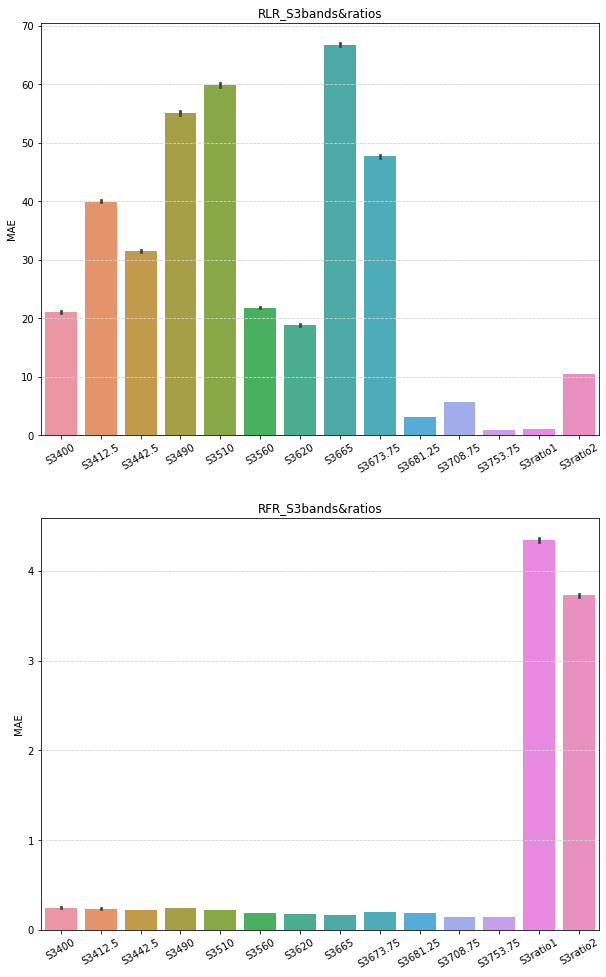

In [10]:
##Plotting the feature importance
fig,axs = plt.subplots(2,1,figsize=(10,20))
axs = axs.flatten()
for ax,model in zip(axs,[m+"_"+b for m in ['RLR', 'RFR'] for b in ["S3bands&ratios"]]):
    b = model.split("_")[1]
    m = model.split("_")[0]
    sns.barplot(x="variable", y="mean_absolute_error", data=sal[(sal["band"] == b) & (sal["model"] == m)],
                ax=ax)
    ax.yaxis.grid(color='lightgrey', linestyle='dashed')
    ax.patch.set_facecolor('white')
    ax.set_ylabel("MAE")
    ax.set_xlabel("")
    ax.set_title(model)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

plt.subplots_adjust(bottom=0.25)

## Predicted vs measured plots
[Table of Contents](#Table-of-Contents)

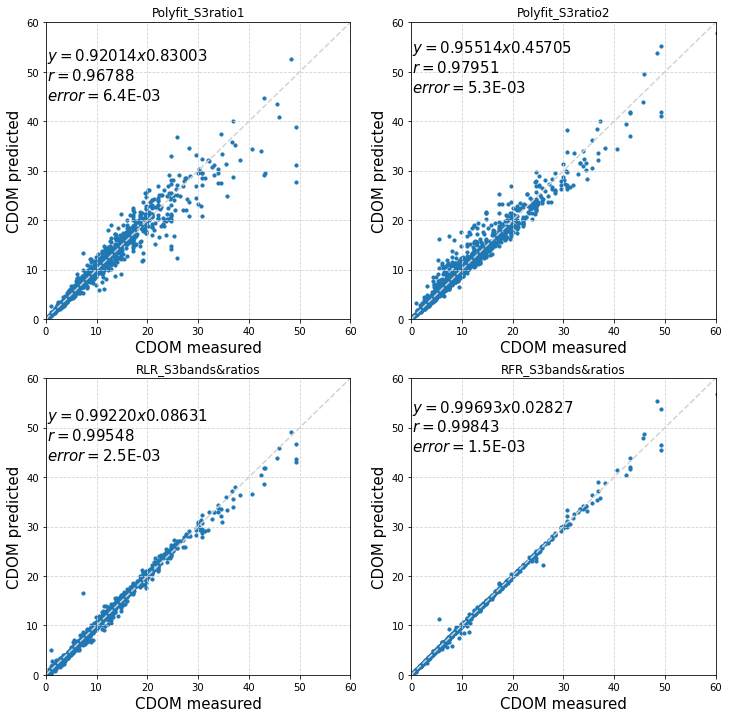

In [11]:
##Generation of linear regression or scatter plots to compare measured vs. predicted values
fig,axs = plt.subplots(2,2,figsize=(12,12))

axs = axs.flatten()
for ax,model in zip(axs,["Polyfit_S3ratio1","Polyfit_S3ratio2","RLR_S3bands&ratios","RFR_S3bands&ratios"]):
    Py4R_plots.correlative_plot(table_preds[model],skdata_y_test,ax=ax)
    ax.set_title(model)

## Regressions with ratios
[Table of Contents](#Table-of-Contents)

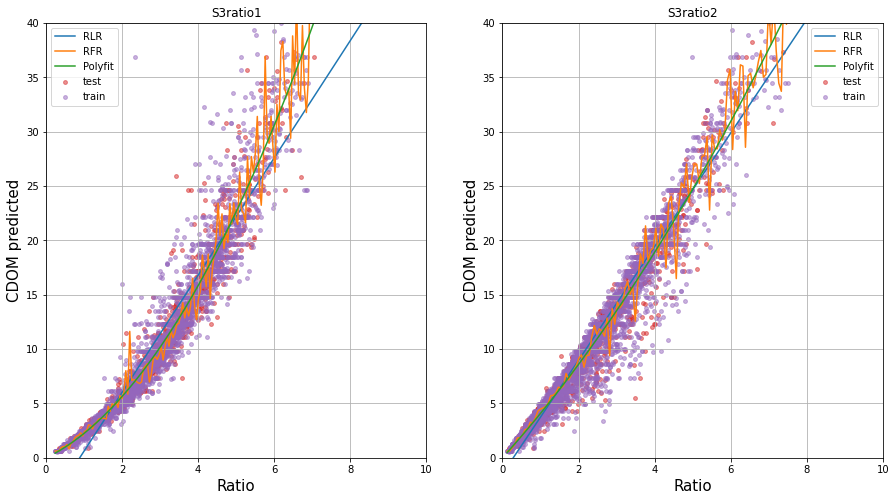

In [12]:
##Ratios of bands are the most simple model for CDOM retrievals
fig,axs = plt.subplots(1,2,figsize=(15,8))

for ratio,ax in zip(["S3ratio1","S3ratio2"],axs):
    X_test = skdata_X_test[data_load_SYKE_S3.bands_try_SYKE[ratio][0]].values
    X_train = skdata_X_train[data_load_SYKE_S3.bands_try_SYKE[ratio][0]].values
    
    models_predict = [(m,modelos[m+"_"+ratio]) for m in models.ALL_NAME_MODELS]
    Py4R_plots.regression_plot(X_train,X_test,skdata_y_train,
                               skdata_y_test,models_predict,mean_y_train,ax=ax)
    ax.set_title(ratio)
    ax.set_xlim(0,10)
    ax.set_ylim(0,40)
    ax.grid()
    ax.legend()

## Runtime analysis
[Table of Contents](#Table-of-Contents)

In [18]:
##To consider how much time takes training the different models
import pandas as pd
datos = pd.read_json("times_C2X_all.json")
datos_largo = pd.melt(datos)
datos_largo["model"] = datos_largo["variable"].apply(lambda x: x[:3] if not x.startswith("Pol") else x[:7])
datos_largo["inputs"] = datos_largo["variable"].apply(lambda x: x[4:] if not x.startswith("Pol") else x[8:])

Text(0, 0.5, 'time (s)')

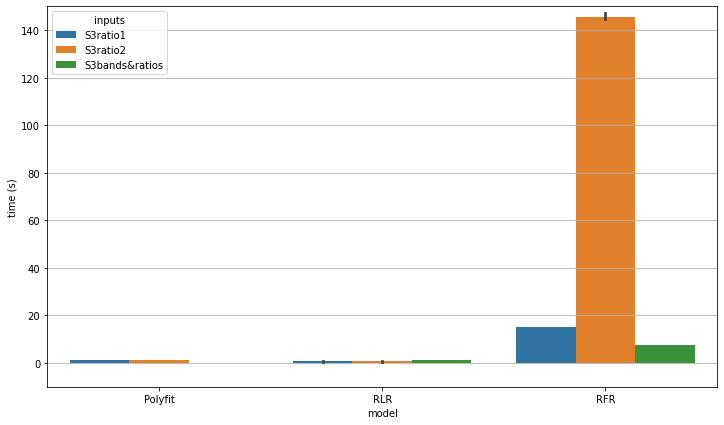

In [19]:
plt.figure(figsize=(12,7))
plt.grid(axis="y")
sns.barplot(hue="inputs",x="model", y="value",data=datos_largo,
            order=["Polyfit","RLR","RFR"],
            hue_order=["S3ratio1","S3ratio2","S3bands&ratios"])
plt.ylim(-10,150)
plt.ylabel("time (s)")